In [1]:
"""
Expects a csv file with image id, maxlat, maxlon, minlat, minlon of each satellite image
Expects json files as a folder with the polygons parsed from the shapefile
Expects images for overlaying masks on images

"""

import json
import numpy as np
import pandas as pd
import sys
import os
# import cv2
import imageio
import csv
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import defaultdict
from copy import deepcopy

import geopandas as gpd
import fiona
from pyproj import Proj
import gdal
import ogr
import osr

import shapely
from shapely import wkt
from shapely.geometry import Polygon
from shapely.geometry import shape
from functools import partial
from shapely.ops import transform
from shapely.strtree import STRtree

# Helper functions

In [2]:
def create_empty_overlays(grid, orig_images_dir, prefix='', suffix='', img_type='.tif', n=100):
    """
    Initiate empty masks and original images into the output folder based on the
    
    Args:
        grid (list): information from csv, so the empty masks to be overwritten later
    """
    count = 0
    for index in grid.keys():
        image_id = grid[index]['image_id']
        #image_id = str(grid[index]['image_id']).zfill(4)
        if count > n:
            break
            
        im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + img_type)
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)
        count += 1

def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

def scale_coords(shape_size, geom, grid, index):
    """
    scales the polygons lat/lon to pixel 
    Args:
        shape_size (tuple): size of the image to be scaled to
        geom (polygon): field polygon
        grid (list): values of min/max lat/lon for each image id
        index (int): Index of each image id in grid

    Returns:
        list: scaled coordinates
    """
    w, h = shape_size
    min_lat, min_lon, max_lat, max_lon = grid[index]['min_lat'], grid[index]['min_lon'], \
        grid[index]['max_lat'], grid[index]['max_lon']
    x = geom[:,0]
    y = geom[:,1]
    scale_lon = w/(max_lon - min_lon)
    scale_lat = h/(max_lat-min_lat)
    scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
    scaled_y = h - ((y - min_lat) * scale_lat)
    if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) \
        or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
        return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
    return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

# Setup

In [3]:
def get_grid(df):
    """
    Read the CSV file containing minmax lat/lon and stores it to a 2D list

    Args:
        df: pandas dataframe of bounding boxes

    Returns:
        list: contains the imag_id and lat/long information
    """
    grid = dict()
    keys = ['max_lat', 'max_lon', 'min_lat', 'min_lon']

    for index, row in df.iterrows():
        if index not in grid:
            grid[index] = dict()
        grid[index]['image_id'] = row['image_id']
        grid[index]['max_lat'] = float(row['max_lat'])
        grid[index]['max_lon'] = float(row['max_lon'])
        grid[index]['min_lat'] = float(row['min_lat'])
        grid[index]['min_lon'] = float(row['min_lon'])
        
    return grid

### Planet images

In [4]:
# ======================== USER SETUP ======================== #
# Directories to read the necessary files from
# base_dir = '../data/planet/india/random'
# base_dir = '../data/planet/india/geowiki/'
# base_dir = '../data/planet/india/GeneralBlockchain/'
# label_folder = 'extent_labels/'
# overlay_folder = 'overlays/'

# csv_file = os.path.join(base_dir, 'bbox1000.csv')
# json_file = '../data/planet/india/json_polys/bbox1000_labeled1600.json'
# csv_file = os.path.join(base_dir, 'geowiki_maharashtra.csv')
# json_file = '../data/planet/india/geowiki/json_polys/geowiki_labeled259.json'
# orig_images_dir = '../data/planet/india/geowiki'

# samples
# csv_file = os.path.join(base_dir, 'bbox_india_GB_v1.csv')
# json_file = os.path.join(base_dir, 'bbox_images26405_samples.json')
# base_dir = '../data/planet/india/GeneralBlockchain/'
# label_folder = 'extent_labels/'
# overlay_folder = 'overlays/'

# large full images
base_dir = '../data/planet/india/GeneralBlockchain/'
csv_file = os.path.join(base_dir, 'bbox_india_GB_download_v2.csv')
json_file = os.path.join(base_dir, 'json_polys/bbox_images10027.json')
label_folder = 'extent_labels_large_for_IoU/'
overlay_folder = 'overlays_large/'

orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', '2020_10')

year_month = '_2020_10'
thickness = 2
# ============================================================ #

df = pd.read_csv(csv_file)
df['image_id'] = df['image_id'].astype(str).str.zfill(4)
df = df.sort_values('image_id').reset_index(drop=True)
grid = get_grid(df)

# Run label generation

In [5]:
# create output directory if not exist
if os.path.exists(os.path.join(base_dir, label_folder)) == False:
    os.makedirs(os.path.join(base_dir, label_folder))
if os.path.exists(os.path.join(base_dir, overlay_folder)) == False:
    os.makedirs(os.path.join(base_dir, overlay_folder))

## General Blockchain images

In [6]:
# temp - only downloaded "c" images
# new_grid = {}
# for key in grid:
#     if 'b' in grid[key]['image_id']:
#         new_grid[key] = grid[key]
new_grid = grid

### Planet images

Steps to rasterize polygons:
1. Reproject fields to same projection as Planet images.
2. Buffer borders of fields.
3. Draw fields onto raster with value 1.
4. Draw buffered borders onto raster with value 0.

In [13]:
# reproject fields to image CRS
# fields = gpd.read_file('../mount/data/GeneralBlockchain/campaign_results/india_fields_with_area.shp')
# img = gdal.Open('../data/planet/india/GeneralBlockchain/' +
#                 'monthly_mosaics_renamed_clipped_merged/2020_10/0163_2020_10.tif')
# proj = osr.SpatialReference(wkt=img.GetProjection())
# print(proj.GetAttrValue('AUTHORITY', 1)) # 3857

# fields = fields.to_crs(epsg=3857)
# fields.to_file('../data/general_blockchain/india_fields_with_area_reprojected.shp')

3857


In [7]:
csv_file = '../data/planet/india/GeneralBlockchain/bbox_india_GB_download_v2.csv'
bbox_df = pd.read_csv(csv_file)
bbox_df['image_id'] = bbox_df['image_id'].astype(str).str.zfill(4)
bbox_df = bbox_df.sort_values('image_id').reset_index(drop=True)

#### Add unique ID to each field

In [9]:
fields = gpd.read_file('../data/general_blockchain/india_fields_with_area_reprojected.shp')

In [10]:
fields['field_id'] = np.arange(fields.shape[0])

In [13]:
fields.to_file('../data/general_blockchain/india_fields_with_area_reprojected_id.shp')

#### Write extent to file

In [14]:
month = '2020_10'
img_folder = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/{}/'.format(month)
label_folder = '../data/planet/india/GeneralBlockchain/extent_labels_gdal_for_IoU/'
if not os.path.exists(label_folder):
    os.makedirs(label_folder)

fn_vec = '../data/general_blockchain/india_fields_with_area_reprojected_id.shp'
vec_ds = ogr.Open(fn_vec)
lyr = vec_ds.GetLayer()

for i, row in bbox_df.iterrows():
    img_name = row['image_id'] + '_' + month + '.tif'
    label_name = row['image_id'] + '.tif'
    fn_ras = os.path.join(img_folder, img_name)
    
    if os.path.exists(fn_ras):
    
        ras_ds = gdal.Open(fn_ras)
        geot = ras_ds.GetGeoTransform()

        out_net = os.path.join(label_folder, label_name)
        drv_tiff = gdal.GetDriverByName("GTiff") 
        chn_ras_ds = drv_tiff.Create(out_net, ras_ds.RasterXSize, 
                                     ras_ds.RasterYSize, 1, gdal.GDT_Float32)
        chn_ras_ds.SetGeoTransform(geot)

        gdal.RasterizeLayer(chn_ras_ds, [1], lyr, options=["ATTRIBUTE=field_id"])
        chn_ras_ds.GetRasterBand(1).SetNoDataValue(0.0) 
        chn_ras_ds = None

#### Write borders to separate file

In [60]:
# month = '2020_10'
# img_folder = '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/{}/'.format(month)
# label_folder = '../data/planet/india/GeneralBlockchain/border_labels_gdal/'

# fn_vec2 = '../data/general_blockchain/india_fields_borders.shp'
# vec_ds2 = ogr.Open(fn_vec2)
# lyr2 = vec_ds2.GetLayer()

# for i, row in bbox_df.iterrows():
#     img_name = row['image_id'] + '_' + month + '.tif'
#     label_name = row['image_id'] + '.tif'
#     fn_ras = os.path.join(img_folder, img_name)
    
#     if os.path.exists(fn_ras):
    
#         ras_ds = gdal.Open(fn_ras)
#         geot = ras_ds.GetGeoTransform()

#         out_net = os.path.join(label_folder, label_name)
#         drv_tiff = gdal.GetDriverByName("GTiff") 
#         chn_ras_ds = drv_tiff.Create(out_net, ras_ds.RasterXSize, 
#                                      ras_ds.RasterYSize, 1, gdal.GDT_Float32)
#         chn_ras_ds.SetGeoTransform(geot)

#         gdal.RasterizeLayer(chn_ras_ds, [1], lyr2)
#         chn_ras_ds.GetRasterBand(1).SetNoDataValue(0.0) 
#         chn_ras_ds = None

#### Subtract borders from extent, convert to PNG

In [32]:
extent_folder = '../data/planet/india/GeneralBlockchain/extent_labels_gdal_for_IoU/'
border_folder = '../data/planet/india/GeneralBlockchain/border_labels_gdal/'
final_folder = '../data/planet/india/GeneralBlockchain/extent_labels_large_for_IoU/'

for i, row in bbox_df.iterrows():
    label_name = row['image_id'] + '.tif'
    extent = imageio.imread(os.path.join(extent_folder, label_name))
    border = np.array(imageio.imread(os.path.join(border_folder, label_name)), dtype=np.uint16) / 255 * 20000
    final_label = np.array(np.maximum(extent-border, 0), dtype=np.uint16)
    np.save(os.path.join(final_folder, row['image_id'] + '.npy'), final_label)

#### Save val and test set labels

In [44]:
splits_df = pd.read_csv('../data/splits/india_planetImagery_splits_20x20_v2.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)

In [46]:
extent_dir = '../data/planet/india/GeneralBlockchain/extent_labels_large_for_IoU/'
# save_dir = '../data/planet/india/GeneralBlockchain/extent_labels_val_for_IoU/'
save_dir = '../data/planet/india/GeneralBlockchain/extent_labels_test_for_IoU/'
extent_names = sorted(os.listdir(extent_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for extent_name in extent_names:
    if extent_name[:-4] in splits_df[splits_df['fold'] == 'test']['image_id'].values:
#     if extent_name[:-4] in splits_df[splits_df['fold'] == 'val']['image_id'].values:
        extent = np.load(os.path.join(extent_dir, extent_name))
        nrow, ncol = extent.shape
        center_row, center_col = nrow // 2, ncol // 2
        final_extent = extent[center_row-128:center_row+128, center_col-128:center_col+128]

        # check edges don't touch fields
        if np.sum(final_extent[:1,:]) > 0 or np.sum(final_extent[-1:,:]) > 0 or np.sum(final_extent[:,:1]) > 0 or np.sum(final_extent[:,-1:]) > 0:
            print("field touches edge on extent {}".format(extent_name))

        # check at least 5 fields
    #     n_connected_components = cv2.connectedComponents(final_extent)[0]
    #     if n_connected_components < 6:
    #         print("extent {} has fewer than 5 fields".format(extent_name))
    #         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #         plt.imshow(final_extent, cmap='Greys_r')
    #         plt.show()

        np.save(os.path.join(save_dir, extent_name), final_extent)

### Visualize labels

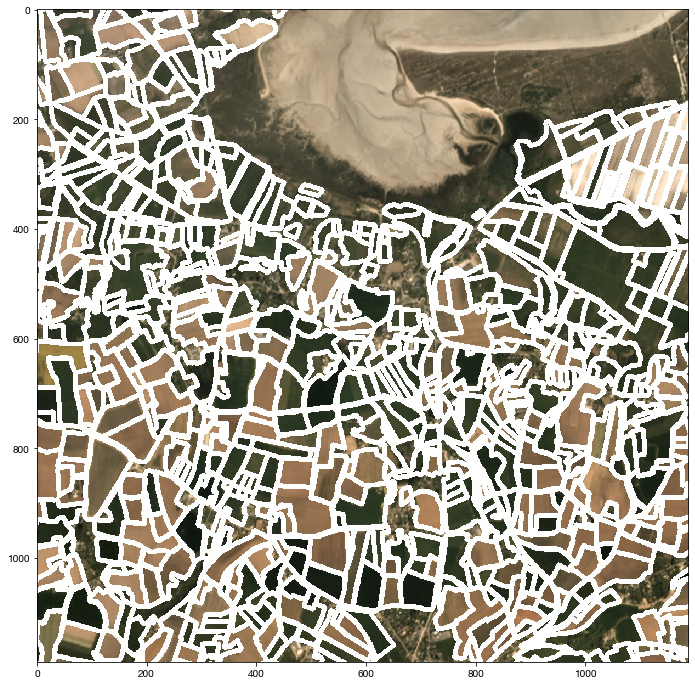

In [55]:
label = imageio.imread('../data/planet/france/sherrie10k/overlays/1250px/00022.jpeg')
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.imshow(label)
plt.show()

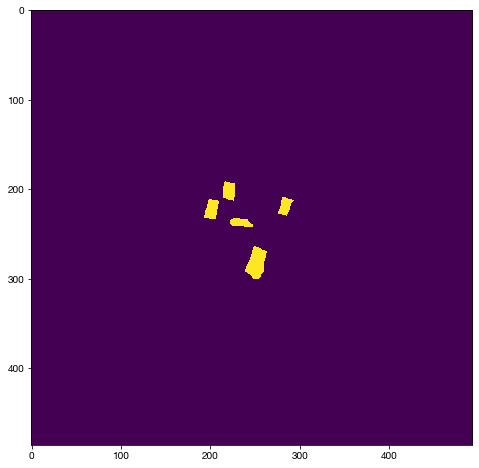

In [63]:
# new label
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large_v2/0001.png')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label, interpolation='nearest')
plt.show()

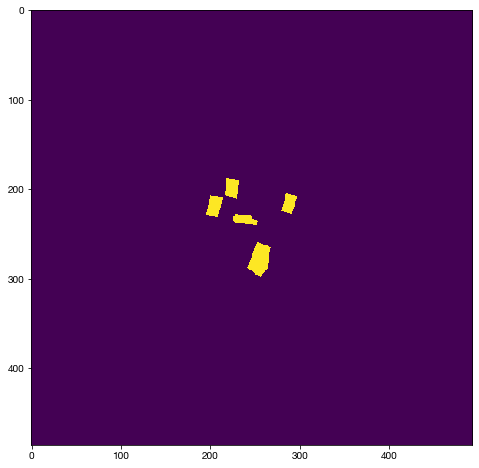

In [60]:
# new label
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large/0001.png')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label)
plt.show()

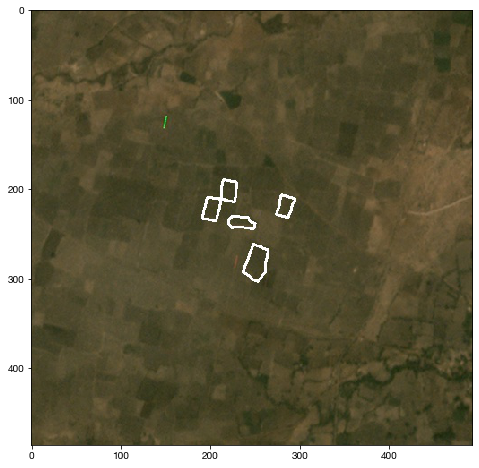

In [61]:
# new label
label = imageio.imread('../data/planet/india/GeneralBlockchain/overlays_large_v2/0001.jpeg')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label)
plt.show()

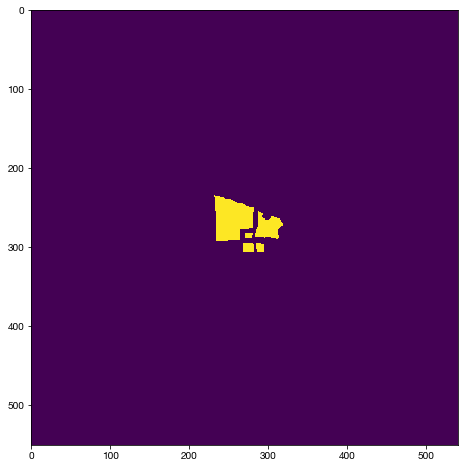

In [59]:
# new label
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large_v2/0005.png')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label, interpolation='nearest')
plt.show()

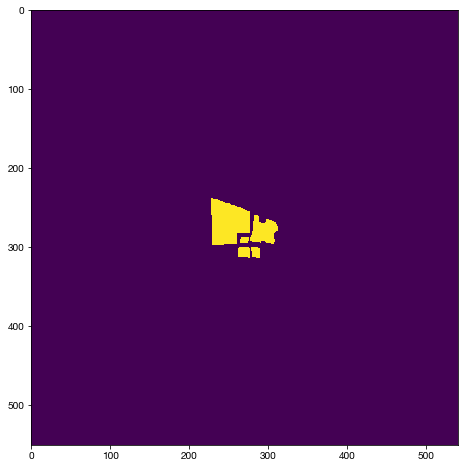

In [2]:
# new label
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large/0005.png')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label)
plt.show()

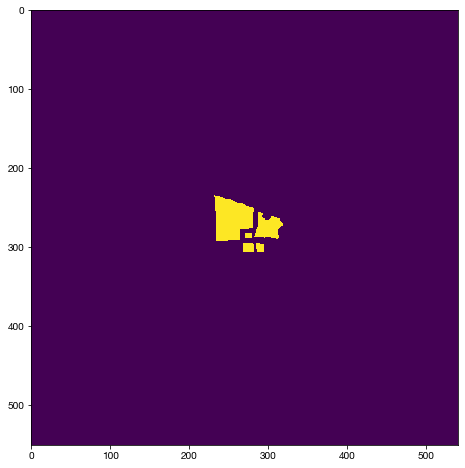

In [18]:
# old label
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_large/0005.png')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label)
plt.show()

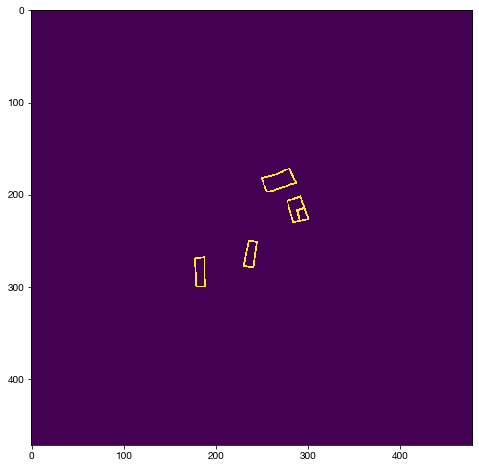

In [56]:
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_gdal/0000.tif')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label)
plt.show()

## Old method

In [85]:
count_parcels = defaultdict(int)
num_fields_parsed = 0

# read multiple json files
print('Read json', json_file)

# open the saved json file for the found parcels in the images 
with open(json_file) as f:
    shp_dict = json.load(f)

# create dictionary of polygons in each image for fast indexing
parcels_dict = create_dict_parcels(shp_dict)

# find the polygons of each image and plot them
for index in new_grid.keys():
    
    # TODO: REMOVE THIS
    if index > 20:
        break

    image_id = int(new_grid[index]['image_id'])
    polys = []
    if image_id in parcels_dict:
#         print(image_id)
        img = imageio.imread(os.path.join(orig_images_dir, str(image_id).zfill(4) + '{}.tif'.format(year_month)))
        shape_size = (img.shape[0], img.shape[1])
        extent_path = os.path.join(base_dir, label_folder, str(image_id).zfill(4) + '.png')
        extent_label = np.zeros(shape_size)

        for sh_index, sh in enumerate(parcels_dict[image_id]):
            count_parcels[image_id] += 1 
            for coord_idx in range(len(sh['geometry']['coordinates'])):
                geom = np.array(sh['geometry']['coordinates'][coord_idx])
                try:
                    geom_fixed = scale_coords(shape_size, geom, new_grid, index)
                except:
                    print("Exception in image {}".format(image_id))
                    print(geom)
                pts = geom_fixed.astype(int)
                cv2.fillPoly(extent_label, [pts], color=1)
                polys.append(pts)

        # Save the extent label
#         cv2.polylines(extent_label, polys, True, color=0, thickness=thickness)
#         cv2.imwrite(extent_path, extent_label)

        # Saves the overlay file
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id).zfill(4) + '.jpeg')
        if os.path.exists(overlay_path):
            orig_image = cv2.imread(os.path.join(orig_images_dir, str(image_id).zfill(4) + year_month + '.tif'))
            cv2.imwrite(overlay_path, orig_image)
            orig_image = cv2.imread(overlay_path)
            cv2.polylines(orig_image, polys, True, color=(255,255,255), thickness=thickness)
            cv2.imwrite(overlay_path, orig_image)
            print('saved image ', image_id)

Read json ../data/planet/india/GeneralBlockchain/json_polys/bbox_images10027.json
saved image  0
saved image  1
saved image  2
saved image  3
saved image  4
saved image  5
saved image  6
saved image  7
saved image  8
saved image  9
saved image  10
saved image  11
saved image  12
saved image  13
saved image  14
saved image  15
saved image  16
saved image  17
saved image  18
saved image  19
saved image  20


### Verify labels

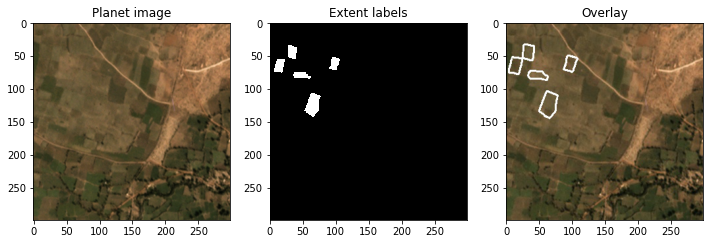

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

image_id = '0001b'

mask = imageio.imread(
    '../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged/2019_12/{}.tif'.format(
    image_id + year_month))
ax[0].imshow(mask)
ax[0].set_title('Planet image')

extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels/{}.png'.format(image_id))
ax[1].imshow(extent, cmap='Greys_r', interpolation='nearest', vmin=0, vmax=1)
ax[1].set_title('Extent labels')

overlay = imageio.imread('../data/planet/india/GeneralBlockchain/overlays/{}.jpeg'.format(image_id))
ax[2].imshow(overlay)
ax[2].set_title('Overlay')

plt.show()